In [31]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json

In [32]:
models = [
    #("/local/scratch/clmn1/octree_study_new/Experiments/pesoLargeGroupNorm_OctreeNCA2DSegmentation/", "OctreeLGN"),
    #("/local/scratch/clmn1/octree_study_new/Experiments/pesoS10GN_OctreeNCA2DSegmentation/", "OctreeGN"),
    #("/local/scratch/clmn1/octree_study_new/Experiments/pesoS10NN_OctreeNCA2DSegmentation/", "OctreeNN"),
    #("/local/scratch/clmn1/octree_study_new/Experiments/pesoLarge_OctreeNCA2DSegmentation/", "OctreeL"),
    ("/local/scratch/clmn1/octree_study_new/Experiments/peso_med_OctreeNCA2DSegmentation/", "Med-NCA"),
    #("/local/scratch/clmn1/octree_study_new/Experiments/peso_OctreeNCA2DSegmentation/", "OctreeNCA"),
    ("/local/scratch/clmn1/octree_study_new/Experiments/pesofFixAbl_none_10_1.0_16_3_1.0_0.99_OctreeNCA2DSegmentation/", "OctreeNCA"),

    ("/local/scratch/clmn1/octree_study_new/Experiments/peso_UNet_efficientnet-b0_0_MinUNet2DSegmentation/", "Efficientnet"),#UNet Efficientnet
    ("/local/scratch/clmn1/octree_study_new/Experiments/peso_UNet_mobilenet_v2_0_MinUNet2DSegmentation/", "Mobilenetv2"),#UNet Mobilenetv2
    ("/local/scratch/clmn1/octree_study_new/Experiments/peso_UNet_resnet18_0_MinUNet2DSegmentation/", "Resnet18"),#UNet Resnet18
    ("/local/scratch/clmn1/octree_study_new/Experiments/peso_UNet_vgg11_0_MinUNet2DSegmentation/", "VGG11"),#UNet VGG11
    ("/local/scratch/clmn1/octree_study_new/Experiments/peso_UnetPlusPlus_resnet34_0_MinUNet2DSegmentation/", "UNet++"),
    ("/local/scratch/clmn1/octree_study_new/Experiments/peso_unet_UNet2DSegmentation/", "UNet"),
    #("/local/scratch/clmn1/octree_study_new/Experiments/pesoXS_UNet2DSegmentation/", "XS"),
    #("/local/scratch/clmn1/octree_study_new/Experiments/pesoXXS_UNet2DSegmentation/", "XXS"),
    #("/local/scratch/clmn1/octree_study_new/Experiments/pesoXXXS_UNet2DSegmentation/", "XXXS"),
    ("/local/scratch/clmn1/octree_study_new/Experiments/peso_vit_SegFomer2DSegmentation/", "SegFormer"),
]

In [33]:
annnotation_list = []
annotation_dict = {}
all_files = []
for i, (model, model_name) in enumerate(models):
    score = pd.read_csv(f"{model}/eval/standard.csv", sep='\t').loc[:, "PatchwiseDiceScore/0"] * 100

    score_std = score.std()
    score = score.mean()

    mem_allocation = json.load(open(f"{model}/mem_allocation.json"))["byte"]
    num_params = json.load(open(f"{model}/num_params.json"))["num_params"]

    eval_file = {}

    eval_file["model"] = model
    eval_file["mem_allocation"] = mem_allocation
    eval_file["num_params"] = num_params
    eval_file["score"] = score
    eval_file["score_std"] = score_std
    df = pd.DataFrame(index=[i], data=eval_file)
    all_files.append(df)
    annnotation_list.append((num_params, score, model_name))
    annotation_dict[model_name] = (num_params, score)

all_files = pd.concat(all_files)

In [34]:
from IPython.display import display, HTML
display(HTML(all_files.to_html()))

,model,mem_allocation,num_params,score,score_std
0,/local/scratch/clmn1/octree_study_new/Experiments/peso_med_OctreeNCA2DSegmentation/,7379063296,7488,84.406179,4.595625
1,/local/scratch/clmn1/octree_study_new/Experiments/pesofFixAbl_none_10_1.0_16_3_1.0_0.99_OctreeNCA2DSegmentation/,2415951360,15520,86.307570,4.835474
2,/local/scratch/clmn1/octree_study_new/Experiments/peso_UNet_efficientnet-b0_0_MinUNet2DSegmentation/,2875034112,6251469,88.153064,4.651142
3,/local/scratch/clmn1/octree_study_new/Experiments/peso_UNet_mobilenet_v2_0_MinUNet2DSegmentation/,2651219968,6628945,88.203111,4.822111
4,/local/scratch/clmn1/octree_study_new/Experiments/peso_UNet_resnet18_0_MinUNet2DSegmentation/,1671894528,14328209,88.001992,4.773354
5,/local/scratch/clmn1/octree_study_new/Experiments/peso_UNet_vgg11_0_MinUNet2DSegmentation/,2687224832,18254033,87.659853,4.554294
6,/local/scratch/clmn1/octree_study_new/Experiments/peso_UnetPlusPlus_resnet34_0_MinUNet2DSegmentation/,4147731456,26078609,88.226277,4.564245
7,/local/scratch/clmn1/octree_study_new/Experiments/peso_unet_UNet2DSegmentation/,5892843008,36951425,82.788581,4.901306
8,/local/scratch/clmn1/octree_study_new/Experiments/peso_vit_SegFomer2DSegmentation/,534810112,3714658,86.305513,4.839665


In [35]:
sam_performance = pd.read_csv("/local/scratch/clmn1/octree_study_new/Experiments/peso_sam_Sam2DSegmentation/eval/standard.csv", sep='\t').loc[:, "PatchwiseDiceScore/0"] * 100
sam_performance = sam_performance.mean()

sam_num_params = json.load(open("/local/scratch/clmn1/octree_study_new/Experiments/peso_sam_Sam2DSegmentation/num_params.json"))["num_params"]
annotation_dict["SAM"] = (sam_num_params, sam_performance)

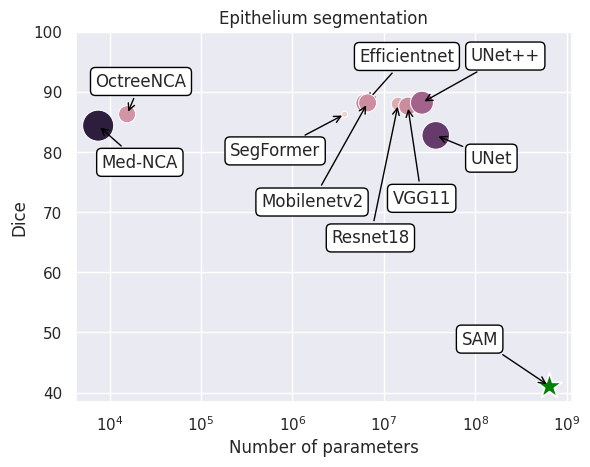

In [55]:
sns.set_theme()
ax = sns.scatterplot(data=all_files, x="num_params", y="score", hue="mem_allocation", size="mem_allocation",legend=False, sizes=(20, 500))
#ax.annotate('SAM', (sam_num_params, sam_performance), textcoords="offset points", xytext=(0,10), ha='center')
scatter = ax.scatter(sam_num_params, sam_performance, color='green', marker='*', s=375, edgecolor='white', linewidth=1.25)
for x,y,txt in annnotation_list:
    #ax.annotate(txt, (x,y), textcoords="offset points", xytext=(0,10), ha='center')
    pass


def my_annotate(name, xytext):
    return ax.annotate(name, annotation_dict[name], textcoords="offset points", xytext=xytext, ha='center',
        bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"),
        arrowprops=dict(arrowstyle="->", color='black'))
    
my_annotate("OctreeNCA", (10, 20))
my_annotate("Med-NCA", (30, -30))
my_annotate("UNet++", (60, 30))
my_annotate("Efficientnet", (30, 30)).zorder = 0.9
my_annotate("UNet", (40, -20))
my_annotate("VGG11", (10, -70))
my_annotate("Mobilenetv2", (-40, -75))
my_annotate("Resnet18", (-20, -100))
my_annotate("SegFormer", (-50, -30))
my_annotate("SAM", (-50, 30))


plt.xscale("log")
plt.xlabel("Number of parameters")
plt.ylabel("Dice")
plt.title("Epithelium segmentation")
plt.ylim(38.5, 100)
plt.savefig("figures/pathology_segmentation.pdf", bbox_inches='tight')